Train exists: True -> /kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy/train
Valid exists: True -> /kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy/valid
Test exists: True -> /kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy/test


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 180MB/s]


Epoch 1/20
------------------------------
Train Loss: 0.2752 Acc: 0.8916
Valid Loss: 0.1474 Acc: 0.9435
Epoch 2/20
------------------------------
Train Loss: 0.1867 Acc: 0.9345
Valid Loss: 0.1556 Acc: 0.9360
Epoch 3/20
------------------------------
Train Loss: 0.1527 Acc: 0.9499
Valid Loss: 0.1225 Acc: 0.9548
Epoch 4/20
------------------------------
Train Loss: 0.1454 Acc: 0.9547
Valid Loss: 0.1186 Acc: 0.9510
Epoch 5/20
------------------------------
Train Loss: 0.1485 Acc: 0.9489
Valid Loss: 0.1533 Acc: 0.9416
Epoch 6/20
------------------------------
Train Loss: 0.1941 Acc: 0.9311
Valid Loss: 0.1180 Acc: 0.9567
Epoch 7/20
------------------------------
Train Loss: 0.1349 Acc: 0.9566
Valid Loss: 0.1105 Acc: 0.9623
Epoch 8/20
------------------------------
Train Loss: 0.1392 Acc: 0.9547
Valid Loss: 0.1191 Acc: 0.9586
Epoch 9/20
------------------------------
Train Loss: 0.1238 Acc: 0.9586
Valid Loss: 0.1023 Acc: 0.9623
Epoch 10/20
------------------------------
Train Loss: 0.1245 Ac

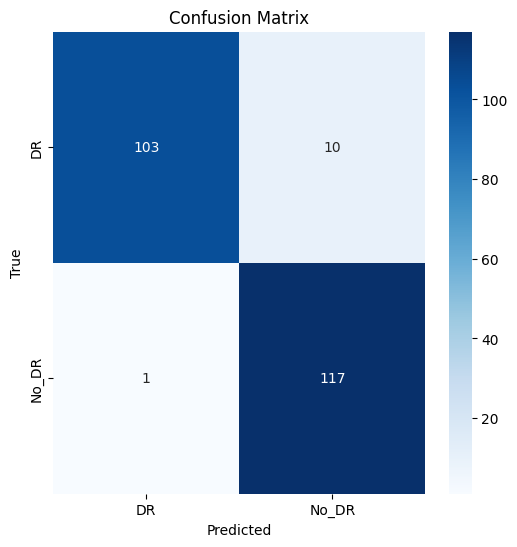


Test Accuracy: 95.24%


In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths to dataset
# Use proper Kaggle dataset path
# Update this if you uploaded your dataset in "Add data" section
# For example, you may change the dataset folder name below if it differs

data_dir = "/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy"
train_dir = os.path.join(data_dir, "train")
valid_dir = os.path.join(data_dir, "valid")
test_dir = os.path.join(data_dir, "test")

# Check if paths exist (debug)
print(f"Train exists: {os.path.exists(train_dir)} -> {train_dir}")
print(f"Valid exists: {os.path.exists(valid_dir)} -> {valid_dir}")
print(f"Test exists: {os.path.exists(test_dir)} -> {test_dir}")

# Transforms
image_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Load Datasets
data = {
    'train': datasets.ImageFolder(train_dir, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(valid_dir, transform=image_transforms['valid']),
    'test': datasets.ImageFolder(test_dir, transform=image_transforms['test'])
}

# DataLoaders
dataloaders = {
    x: DataLoader(data[x], batch_size=32, shuffle=True, num_workers=4)
    for x in ['train', 'valid', 'test']
}

# Model - Transfer Learning with ResNet18
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False  # Freeze feature extractor

# Replace the final fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 2)
)

model = model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Training loop
def train_model(model, criterion, optimizer, num_epochs=20):
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-"*30)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(data[phase])
            epoch_acc = running_corrects.double() / len(data[phase])

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    print(f"\nBest Validation Accuracy: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model

# Train the model
model = train_model(model, criterion, optimizer, num_epochs=20)

# Test evaluation with visualization
def evaluate_model(model, dataloader, class_names):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    acc = np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)
    print(f"\nTest Accuracy: {acc * 100:.2f}%")

# Run final evaluation
class_names = data['test'].classes
evaluate_model(model, dataloaders['test'], class_names)


In [4]:
# Save only the model weights
torch.save(model.state_dict(), "/kaggle/working/retinopathy_model.pth")